---
title: "SVD for image compression"
execute:
  # echo: false
  freeze: auto  # re-render only when source changes
format:
  html:
    code-fold: true
    code-summary: "Show the code"
---

This chapter is partially based on these sources:

* "Data-Driven Science and Engineering: Machine Learning, Dynamical Systems, and Control" by Steven L. Brunton, J. Nathan Kutz. SVD is covered in Chapter 1.
* [Dr. Roi Yehoshua's "Singular Value Decomposition (SVD), Demystified"](https://towardsdatascience.com/singular-value-decomposition-svd-demystified-57fc44b802a0/).

## the image

I will use a black-and-white version of the photo below as the matrix to decompose. There are two reasons to use this image:

1. it is a tall and skinny matrix (width 1600 px, height 2600 px). Tall and skinny matrices are usually used in overdetermined systems, which are common in data science.
2. this is the image of the juice of a tomato I ate, as it fell on the concrete floor. I found this splat pattern so beautiful that I took a picture, and I wanted to immortalize it in this tutorial. You're welcome.

![](/archive/images/splat.jpg)

In [1]:
#| code-summary: "import libraries"
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import time
from sklearn.decomposition import TruncatedSVD

(-0.5, 1599.5, 2599.5, -0.5)

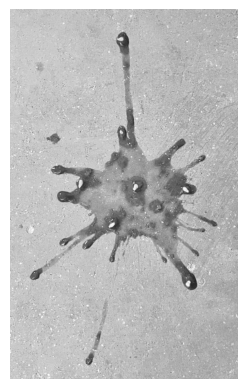

In [2]:
#| code-summary: "load jpg into numpy array, convert to grayscale, and display it"
image = Image.open('../archive/images/splat.jpg')
gray_image = image.convert('L')  # convert to grayscale
image_array = np.array(gray_image)  # make it a numpy array
# display the image
fig, ax = plt.subplots()
ax.imshow(image_array, cmap='gray')
ax.axis('off')  # Hide axis

## decomposition

In [3]:
#| code-summary: "decompose with numpy in one line of code"
#| code-fold: show
U, S, Vt = np.linalg.svd(image_array)

Let's see how the magnitude of the singular values decreases as we go from the first to the last (k goes from zero to 900-1). Also, let's see how much of the total energy accumulated up to the k-th singular value squared.

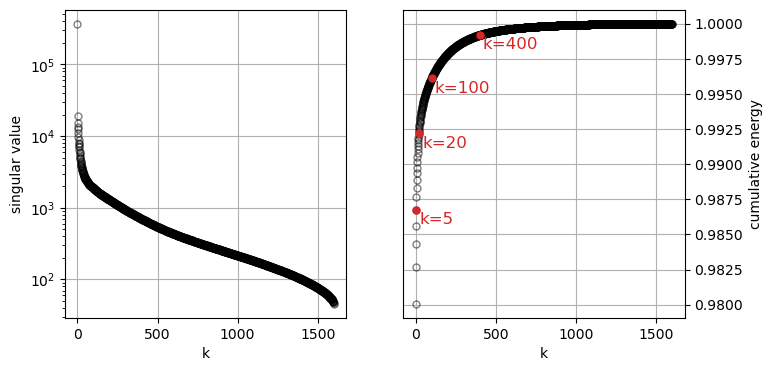

In [4]:
#| code-summary: "plot singular values and cumulative energy"
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
lenS = len(S)
ax[0].plot(np.arange(lenS), S, marker='o', markeredgecolor="black", markerfacecolor='None', markersize=5, linestyle='None', alpha=0.5)
ax[0].set_yscale('log')  # Set y-axis to log scale
ax[0].set(xlabel='k',
          ylabel='singular value'
         )
ax[0].grid(True)  # Enable grid on the first panel

cumS2 = np.cumsum(S**2) / np.sum(S**2)
ax[1].plot(np.arange(lenS), cumS2, marker='o', markeredgecolor="black", markerfacecolor='None', markersize=5, linestyle='None', alpha=0.5)
klist = [5, 20, 100, 400]
for k in klist:
    ax[1].plot([k-1], [cumS2[k-1]], marker='o', markeredgecolor="tab:red", markerfacecolor='tab:red', markersize=5, linestyle='None')
    ax[1].text(k+20, cumS2[k-1]-0.001, f'k={k}', color='tab:red', fontsize=12, ha='left')

ax[1].set(xlabel='k',
          ylabel='cumulative energy'
         )
ax[1].grid(True)  # Enable grid on the second panel
ax[1].yaxis.set_label_position("right")  # Move ylabel to the right
ax[1].yaxis.tick_right()  # Move yticks to the right

The square of the Frobenius norm of the matrix $X$ is equal to the sum of the squares of all its singular values.

$$
\lVert X \rVert_F^2 = \sum_{i=1}^{r} \sigma_i^2
$$

The Frobenius norm is a measure of the "magnitude" or "size" of the matrix, which can be interpreted as the total amount of "information" in the data. By taking the cumulative sum of the squared singular values, we are effectively measuring how much of this total information is retained with each successive truncation. The term "energy" is an analogy from physics and signal processing. In these fields, the total energy of a signal is often defined as the integral of its squared magnitude over time. This concept carries over to data analysis where the squared singular values are a direct measure of the variance in the data along each singular vector, and the sum of these squares represents the total variance.

## truncation and reconstruction

Our original matrix $X$ has dimensions (1600, 2600) and rank 1600. Therefore, it has 1600 non-zero singular values. We can truncate the SVD to a lower rank $k < 1600$ and reconstruct an approximation of the original matrix using only the first $k$ singular values and their corresponding singular vectors:

$$
X_k = U_k \Sigma_k V_k^T = \sum_{i=1}^{k} \sigma_i \cdot \text{outer}(u_i, v_i^T)
$$

where $U_k$ is the matrix of the first $k$ left singular vectors, $\Sigma_k$ is the diagonal matrix of the first $k$ singular values, and $V_k^T$ is the transpose of the matrix of the first $k$ right singular vectors. The outer product $\text{outer}(u_i, v_i^T)$ creates a rank-1 matrix from the $i$-th left and right singular vectors.

Using the same truncation values $k$ shown in red in the plot above, we can reconstruct approximations of the original image. As $k$ increases, the reconstructed image becomes more detailed and closer to the original image.

In [5]:
#| code-summary: "reconstruct image from first k singular values/vectors"
def reconstruct_image(U, S, Vt, k):
    X_reconstructed = np.zeros_like(image_array, dtype=np.float64)
    for i in range(k): 
        X_reconstructed += S[i] * np.outer(U[:, i], Vt[i, :])   
    X_reconstructed = np.clip(X_reconstructed, 0, 255)  # ensure values are in byte range
    X_reconstructed = X_reconstructed.astype(np.uint8)  # convert to uint8
    return X_reconstructed

reconstructed_images = []
for k in klist:
    X_reconstructed = reconstruct_image(U, S, Vt, k)
    reconstructed_images.append(X_reconstructed)

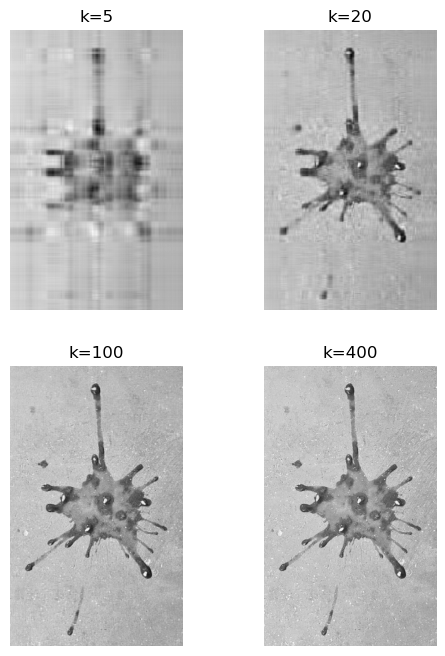

In [6]:
#| code-summary: "visualize reconstructed images"
fig = plt.figure(figsize=(6, 8))
for i, k in enumerate(klist):
    ax = fig.add_subplot(2, 2, i+1)
    X_k = reconstructed_images[i]
    ax.imshow(X_k, cmap='gray')
    ax.set_title(f'k={k}')
    ax.axis('off')  # Hide axis

The truncation for $k=5$ gives a blurry image, but for $k=20$ it is recognizably a tomato splat. The reconstructions for $k=100$ and $k=400$ seem indistinguishable at this resolution. Let's zoom in on a small section of the image to see the differences more clearly.

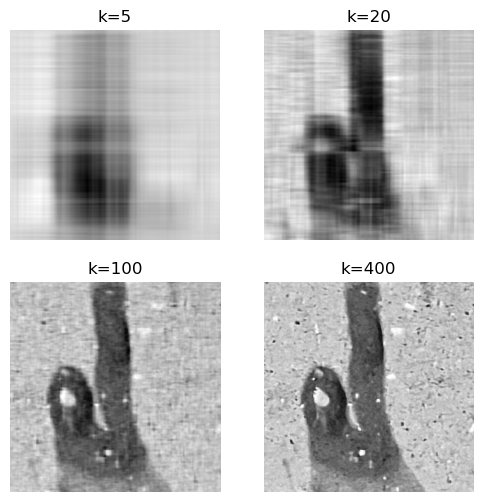

In [7]:
#| code-summary: "visualize zoomed in reconstructed images"
fig = plt.figure(figsize=(6, 6))
for i, k in enumerate(klist):
    ax = fig.add_subplot(2, 2, i+1)
    X_k = reconstructed_images[i][700:1000, 700:1000]  # zoom in
    ax.imshow(X_k, cmap='gray')
    ax.set_title(f'k={k}')
    ax.axis('off')  # Hide axis

To capture all the details in the concrete floor we need more than 100 singular values. If we're interested in the overall shape of the splat, 100 singular values are more than enough. This justifies the name of this chapter: **SVD for image compression**. We can compress images by storing only the first $k$ singular values and their corresponding singular vectors, instead of the entire image matrix.

## computational efficiency

We calculated the reconstruction "the hard way", by explicitly forming the outer products and summing them. However, we can also use matrix multiplication to achieve the same result more efficiently.

$$
X_k = U_k \Sigma_k V_k^T
$$
where:

* $U_k$ is the matrix formed by the first $k$ columns of $U$.
* $\Sigma_k$ is the $k \times k$ diagonal matrix formed by the first $k$ singular values, $\Sigma_{11}=\sigma_1$, $\Sigma_{22}=\sigma_2$, etc.
* $V_k^T$ is the matrix formed by the first $k$ rows of $V^T$.

Let's leverage matrix multiplication to compute the reconstruction: $X_k = U_k (\Sigma_k V_k^T)$.

First, let's look at the product of the diagonal singular value matrix $\Sigma_k$ and the truncated $V^T$ matrix, $V_k^T$.
$\Sigma_k$ is a $k \times k$ diagonal matrix with singular values $\sigma_1, \sigma_2, ..., \sigma_k$ on the diagonal.
$V_k^T$ is a $k \times n$ matrix where each row is a singular vector $v_i^T$.

$$
\Sigma_k V_k^T = \begin{bmatrix}
\sigma_1 & 0 & \dots & 0 \\
0 & \sigma_2 & \dots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \dots & \sigma_k
\end{bmatrix}
\begin{bmatrix}
— & v_1^T & — \\
— & v_2^T & — \\
& \vdots & \\
— & v_k^T & —
\end{bmatrix}
$$

Multiplying a diagonal matrix by another matrix from the left scales each row of the second matrix by the corresponding diagonal element of the first matrix.
$$
\Sigma_k V_k^T = \begin{bmatrix}
— & \sigma_1 v_1^T & — \\
— & \sigma_2 v_2^T & — \\
& \vdots & \\
— & \sigma_k v_k^T & —
\end{bmatrix}
$$

This matrix contains the scaled singular vectors as its rows.

Now, we multiply the truncated $U$ matrix, $U_k$, with the result from the first step.
$U_k$ is an $m \times k$ matrix whose columns are the singular vectors $u_1, u_2, ..., u_k$.
Let's call the result from the first step, the matrix $A$. The product is $U_k A$.

$$
X_k = U_k A = \begin{bmatrix}
| & | & & | \\
u_1 & u_2 & \dots & u_k \\
| & | & & |
\end{bmatrix}
\begin{bmatrix}
— & \sigma_1 v_1^T & — \\
— & \sigma_2 v_2^T & — \\
& \vdots & \\
— & \sigma_k v_k^T & —
\end{bmatrix}
$$

Matrix multiplication can be seen as a sum of outer products of the columns of the first matrix and the rows of the second matrix.

$$
X_k = \sum_{i=1}^{k} (\text{column } i \text{ of } U_k) \cdot (\text{row } i \text{ of } A)
$$

$$
X_k = \sum_{i=1}^{k} u_i (\sigma_i v_i^T)
$$

$$
X_k = \sum_{i=1}^{k} \sigma_i (u_i v_i^T)
$$

Let's time the two methods of reconstruction to see the efficiency gain from using matrix multiplication.

In [8]:
#| code-fold: false
k = 100

start_time1 = time.time()
X1 = reconstruct_image(U, S, Vt, k)
end_time1 = time.time()

start_time2 = time.time()
X2 = np.dot(U[:, :k], np.dot(np.diag(S[:k]), Vt[:k, :])) 
end_time2 = time.time()

T1 = end_time1 - start_time1
T2 = end_time2 - start_time2

print(f"explicitly computing the outer products: {T1:.6f} seconds")
print(f"leveraging matrix multiplication: {T2:.6f} seconds")
print(f"speedup: {T1/T2:.2f}x")

explicitly computing the outer products: 1.508656 seconds
leveraging matrix multiplication: 0.011750 seconds
speedup: 128.40x


There are two equivalent ways of leveraging matrix multiplication. Because of the associativity of matrix multiplication, we can compute the product in two different orders:

1. First compute $B = \Sigma_k V_k^T$, then compute $X_k = U_k B$.
2. First compute $C = U_k \Sigma_k$, then compute $X_k = C V_k^T$.

For a tall-and-skinny matrix like our image (m>n), the first method is more efficient because it involves multiplying a smaller intermediate matrix $B$ (of size $k \times n$) with $U_k$ (of size $m \times k$). The second method would involve multiplying a larger intermediate matrix $C$ (of size $m \times k$) with $V_k^T$ (of size $k \times n$), which is less efficient. For our 2600x1600 image, the difference is tiny, but for larger datasets it can be significant.

SVD is such a common operation that most numerical computing libraries have highly optimized implementations. See below `sklearn`'s `TruncatedSVD`, which uses `scipy.sparse.linalg.svds` under the hood. It is designed to compute only the first `k` singular values and vectors, making it more efficient for large datasets where only a few singular values are needed.

In [10]:
start_time2b = time.time()
X2b = np.dot(np.dot(U[:, :k], np.diag(S[:k])), Vt[:k, :])
end_time2b = time.time()

svd = TruncatedSVD(n_components=100)
truncated_image = svd.fit_transform(image_array)
start_time3 = time.time()
X3 = svd.inverse_transform(truncated_image)
end_time3 = time.time()

T2b = end_time2b - start_time2b
T3 = end_time3 - start_time3

print(f"matrix multiplication, option 2: {T2b:.6f} seconds")
print(f"using sklearn's TruncatedSVD: {T3:.6f} seconds")

matrix multiplication, option 2: 0.068557 seconds
using sklearn's TruncatedSVD: 0.011218 seconds
